## Packages

In [7]:
import pyvinecopulib as pvcl

import numpy as np
import pandas as pd
import scipy.interpolate as interpolate
import scipy.optimize as optimize

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Data

In [119]:
# generating a multivariate normal distribution
mean = [0., 0.]
matrixSize = 2 
A = np.random.rand(matrixSize, matrixSize)
cov = np.dot(A, A.transpose()) # symmetric positive-semidefinite matrix
df = pd.DataFrame(np.random.multivariate_normal(mean, cov, 1000).T, index=list('AB'))
df

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
A,0.338039,1.193240,-1.578128,2.851718,1.248057,0.674923,-0.656263,1.209704,-1.359567,-1.767539,...,-0.596563,-0.586999,-1.487285,3.495799,-0.683164,-0.962539,1.990474,1.637848,-0.899314,-2.341374
B,-0.447766,0.908379,-1.367419,1.093273,0.944035,0.129405,0.237641,0.411304,0.157212,-0.682143,...,-0.169569,0.117846,-0.404463,1.697272,-0.508760,-0.763308,0.903855,-0.119764,0.068626,-1.962151


In [120]:
# calculate correlation coefficient for data
print(cov[0,1] / np.sqrt(cov[0,0]*cov[1,1]))

0.798059608631


## Data Setup

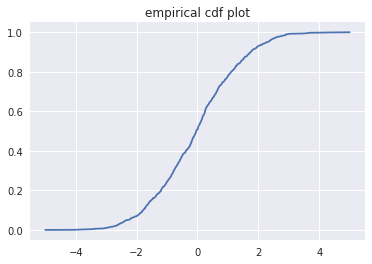

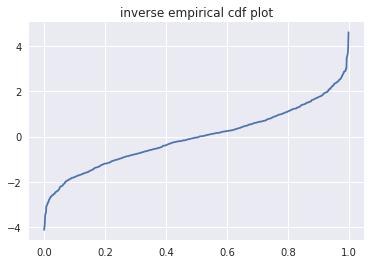

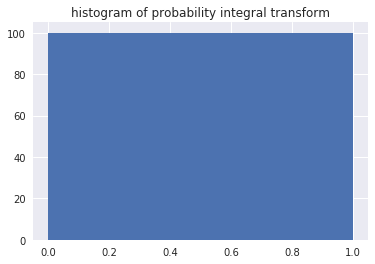

In [121]:
def empirical_cdf(data):
    return data.dropna().rank(axis=1) / (len(data.columns) + 1)

# empirical cdf
emp = empirical_cdf(df)

# empirical cdf plot 
cdf = interpolate.interp1d(df.iloc[0,:], emp.iloc[0,:], fill_value="extrapolate")
x = np.arange(-5, 5, 0.001)
y = cdf(x)
y[y<0]=0; y[y>1]=1
f = plt.figure(1)
plt.title("empirical cdf plot")
plt.plot(x, y)

# inverse cdf
def inverse_cdf(cdf, y):
    def func(x):
        return cdf(x) - y
    return optimize.bisect(func, -15, 15)

v_inverse_cdf = np.vectorize(inverse_cdf)

# inverse empirical cdf plot
x = np.arange(0., 1., 0.001)
y = v_inverse_cdf(cdf, x)
g = plt.figure(2)
plt.title("inverse empirical cdf plot")
plt.plot(x, y)

# empirical cdf histogram
h = plt.figure(3)
plt.title("histogram of probability integral transform")
emp.iloc[0,:].hist(bins=10)

plt.show()

## Fitting a bicopula

In [122]:
# fit general vine copula
fitted = pvcl.bicop(emp.values)

In [115]:
# fit vine copula with controls
fitted = pvcl.bicop()

fit_controls = pvcl.bicop_fit_controls(pvcl.bicop_families.rotationless)
fit_controls.selection_criterion = "aic"
fit_controls.parametric_method = "itau"

fitted.select(emp.values, fit_controls)

In [123]:
fitted.family

pyvinecopulib.bicop_family.gaussian

In [124]:
# access vine copula attributes
print("Pair copula family:")
print(fitted.family)
print("\nParameters:") # verifying fitted correlation coefficient
print(fitted.parameters)
print("\nRotation:")
print(fitted.rotation)

Pair copula family:
gaussian

Parameters:
[[ 0.80030693]]

Rotation:
0


## Simulating from a bicopula

In [140]:
num_draws = 1000
sim_unif = pd.DataFrame(fitted.simulate(num_draws), index=df.index.values)
sim_unif

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
A,0.381115,0.647274,0.455348,0.360114,0.544504,0.963315,0.032532,0.914593,0.662766,0.006929,...,0.465142,0.319290,0.613324,0.146498,0.786665,0.022938,0.08964,0.568035,0.366722,0.834363
B,0.845529,0.966768,0.184381,0.302332,0.311548,0.824520,0.207954,0.882998,0.869375,0.018721,...,0.764220,0.572471,0.508680,0.190046,0.603778,0.159437,0.09344,0.151564,0.521572,0.564564


In [141]:
# flip uniform marginals into actuals
sim_df = sim_unif.copy()

for i in range(len(df.index)):
    cdf = interpolate.interp1d(df.iloc[i,:], emp.iloc[i,:], fill_value="extrapolate")
    sim_df_slice = v_inverse_cdf(cdf, sim_unif.iloc[i,:])
    sim_df.iloc[i,:] = sim_df_slice

sim_df

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
A,-0.477405,0.410210,-0.170441,-0.552431,0.102647,2.437316,-2.537682,1.848519,0.479955,-3.098758,...,-0.150179,-0.706268,0.275327,-1.545692,1.041590,-2.656821,-1.832348,0.159716,-0.530348,1.307460
B,0.779899,1.473908,-0.783822,-0.467397,-0.449816,0.727084,-0.706848,0.939448,0.880485,-1.640012,...,0.536791,0.128547,-0.007010,-0.763760,0.183446,-0.849792,-1.158118,-0.888991,0.002152,0.112029


In [142]:
# verify correlation coefficient for simulated data
print(np.corrcoef(sim_df.iloc[0],sim_df.iloc[1]))

[[ 1.          0.80188333]
 [ 0.80188333  1.        ]]


## Plotting calibration and simulation data

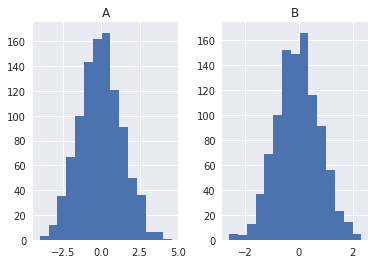

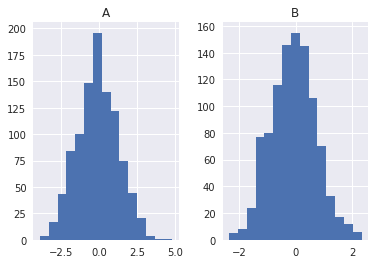

In [143]:
# comparing actual returns and simulated returns univariate distributions
df.T.hist(bins=15)
sim_df.T.hist(bins=15)
f.tight_layout()

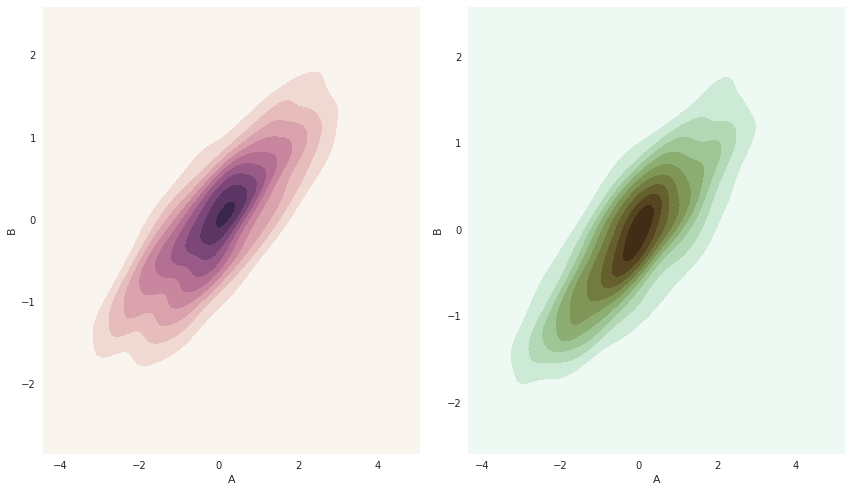

In [145]:
# comparing actual returns and simulated returns bivariate distributions
sns.set(style="dark")
f, axes = plt.subplots(1, 2, figsize=(12, 7))

data = [df.loc['A'], df.loc['B'], sim_df.loc['A'], sim_df.loc['B']]

for ax, s in zip(axes.flat, range(2)):
    cmap = sns.cubehelix_palette(start=s, light=1, as_cmap=True)
    sns.kdeplot(data[2*s],data[2*s+1], cmap=cmap, shade=True,cut=1, ax=ax)

f.tight_layout()